# Maximum likelihood estimation

CPSC 340: Machine Learning and Data Mining

The University of British Columbia

2018 Winter Term 1

By Mike Gelbart (converted to Julia by Jason Chau)

In [38]:
using Distributions
using PyCall
#=run once
using Conda
Conda.add("scipy")
=#
SciPyStats = pyimport("scipy.stats")
using PyPlot
plt = pyimport("matplotlib.pyplot")
using Printf

- Consider the Binomial distribution: you have a coin with probability $w$ of heads.
- Classical probability is about _generating data from the parameters_: that is, tell me $w$ and I'll generate data from you. E.g.

In [21]:
w = 0.25 
n = 100
heads = rand(Binomial(n,w),1);
heads

1-element Array{Int64,1}:
 24

In [22]:
rand(Binomial(n,w),100)

100-element Array{Int64,1}:
 25
 20
 29
 35
 15
 20
 24
 23
 24
 19
 23
 25
 27
  ⋮
 26
 26
 22
 18
 31
 20
 23
 23
 27
 22
 21
 23

In [9]:
randn(10) # a sample of size 10 from the Gaussian distribution

10-element Array{Float64,1}:
 -0.3858200387330659 
  2.3169390426022125 
  0.7493878843540771 
 -0.7359555006797184 
  0.4146762506229487 
 -0.5916005972629046 
  0.18259509810639016
  1.4756846152876903 
  0.5908455036319374 
 -0.39370363352722143

- Now imagine we're going the other direction, which is what typically happens in ML:
  - You assume the distribution is binomial but you don't know $w$
  - You flip the coin 100 times and observe 70 heads... what is $w$?
      - Is $w=0$?
      - Is $w=1$?
      - Is $w=0.5$?
      - Is $w=0.7$?
  - Well, we know the pmf: $P(X=k)={n\choose k} w^k (1-w)^{n-k}$
  - Furthermore, we know $n$ and we've _observed_ $k$
  - Can we reason about $w$?

In [10]:
n = 100
k = 70

70

In [23]:
SciPyStats.binom.pmf(k,n,0) # w=0

0.0

In [24]:
SciPyStats.binom.pmf(k,n,1) # w=1

0.0

In [25]:
SciPyStats.binom.pmf(k,n,0.5) # w=0.5

2.317069058013523e-5

In [26]:
SciPyStats.binom.pmf(k,n,0.7) # w=0.7

0.08678386475342748

Let's do this for many values of $w$ between $0$ and $1$, and make a plot.

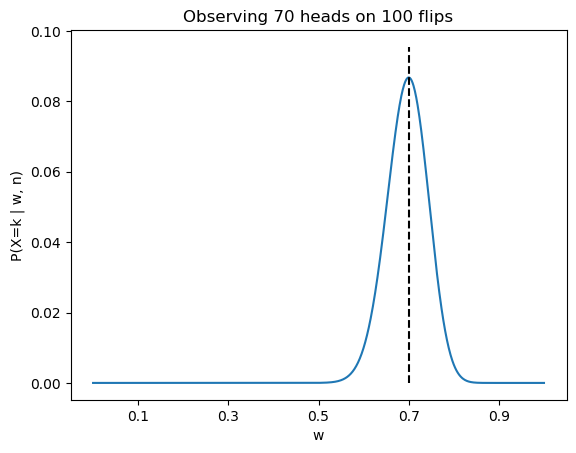

PyObject Text(0.5, 1, 'Observing 70 heads on 100 flips')

In [30]:
n = 100
k = 70

function plot_binom_like(k,n)
    grid = range(0,stop=1,length=1000)
    pmf = SciPyStats.binom.pmf(k,n,grid)
    plt.plot(grid, pmf);
    plt.xlabel("w")
    plt.ylabel("P(X=k | w, n)");
    plt.plot((k/n,k/n),(0,maximum(pmf)*1.1),"--k");
    plt.xticks(0.1:0.2:1);
    plt.title("Observing "*string(k)*" heads on "*string(n)*" flips");
end

plot_binom_like(k,n)

#### Key ideas

- This function tells us the probability of seeing our data given different choices of $w$.
- Maximum likelihood estimation: estimate $w$ by picking the mode (maximum) of this likelihood function.
- In words, I'm going to assume the parameter value(s) that make what I saw most probable. 
  - We're using "what's the probability of seeing what I saw?" as a score for different parameter values.
- However, we're taking this pmf and _thinking of it as a function of $w$ instead of $k$.
  - This is the key insight of MLE!!!
  - Note: this is NOT a probability distribution; it is not normalized (look at the area of the above)
- Note: in this case, although the distribution was discrete, the likelihood function is continuous.
  - That's because the likelihood is a function of the parameter $w$, which in this case is continuous.
  - It's also possible to have discrete parameters.

#### General formula

We want $$\arg \max_w P(X=k \mid w, n)$$

This is $$\arg \max_w {n\choose k} w^k (1-w)^{n-k}$$

We can throw away the parts that don't depend on $w$:

$$\arg \max_w w^k (1-w)^{n-k}$$

Now we can take the derivative w.r.t. $w$ and set to zero (we should also check that it's a maximum; not shown):

$$\frac{dL(w)}{dw}=kw^{k-1}(1-w)^{n-k} - w^k(n-k)(1-w)^{n-k-1}=0$$

After some algebra we get:

$$k(1-w) = (n-k)w$$ or $$w=k/n$$

This result makes sense intuitively: the estimate is the fraction of tosses that landed heads.

But: in general we won't be able to do this in closed form, we'll have to use numerical optimization like gradient descent.

#### Problems with MLE

Here's a situation: you flip the coin once and observe heads. What's the MLE?

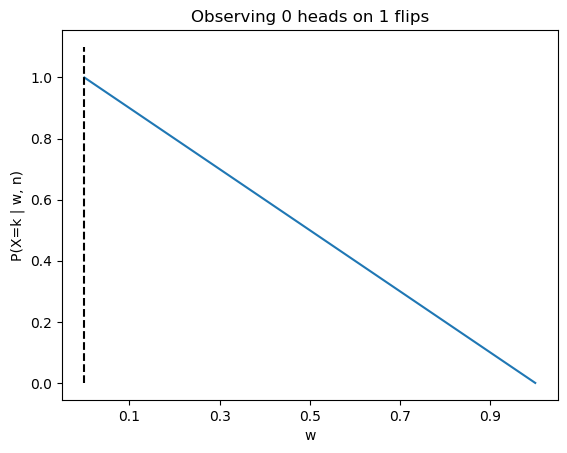

PyObject Text(0.5, 1, 'Observing 0 heads on 1 flips')

In [31]:
plot_binom_like(0,1)- If you see 0 heads in 1 flip, then your MLE is $w=0$
- That seems a little intense!
- More on this next class.

- If you see 0 heads in 1 flip, then your MLE is $w=0$
- That seems a little intense!
- More on this next class.

### A continuous example

Consider the example of modelling student GPAs. We model this with a Gaussian with unknown mean and $\sigma=1$. You observe $4$. What do you think the mean is?

Let's look at the likelihood of the mean.

- The pdf is $p(y \mid \mu, \sigma)=\frac{1}{\sqrt{2\pi \sigma^2}}\exp\left(-\frac{(y-\mu)^2}{2\sigma^2}\right)$
- The likelihood is this function, viewed as a function of $\mu$ (and we can drop the constants): $L(\mu)=\exp\left(-\frac{(4-\mu)^2}{2}\right)$

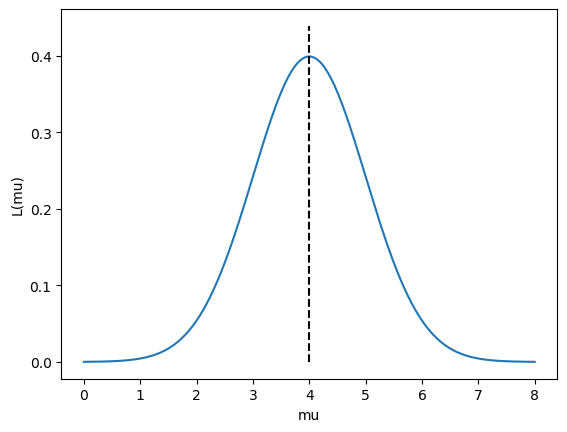

In [32]:
grid = range(0,stop=8,length=1000)
lik = SciPyStats.norm.pdf(4,loc=grid)
plt.plot(grid,lik);
plt.xlabel("mu");
plt.ylabel("L(mu)");
plt.plot((grid[argmax(lik)],grid[argmax(lik)]),(0,maximum(lik)*1.1),"--k");

- In this case, the likelihood function is also Gaussian. The maximum likelihood estimate is $4$. Again, an intuitive result.
- We can also account for multiple observations. E.g. if we saw "4" and "3.2", then, assuming iid samples, we multiply the densities:

$$p(y_1,y_2 \mid \mu, \sigma)=\frac{1}{\sqrt{2\pi \sigma^2}}\exp\left(-\frac{(y_1-\mu)^2}{2\sigma^2}\right) \times \frac{1}{\sqrt{2\pi \sigma^2}}\exp\left(-\frac{(y_2-\mu)^2}{2\sigma^2}\right)$$ if $y_1$ and $y_2$ are independent.

And in general, if we have $n$ iid observations, then the density (and likelihood function) are given by:

$$p(y_1,\ldots,y_n \mid \mu, \sigma)=\prod_{i=1}^n\frac{1}{\sqrt{2\pi \sigma^2}}\exp\left(-\frac{(y_1-\mu)^2}{2\sigma^2}\right) $$

Let's look at this for the observation vector $\begin{bmatrix}4 \\ 3.2 \end{bmatrix}$.

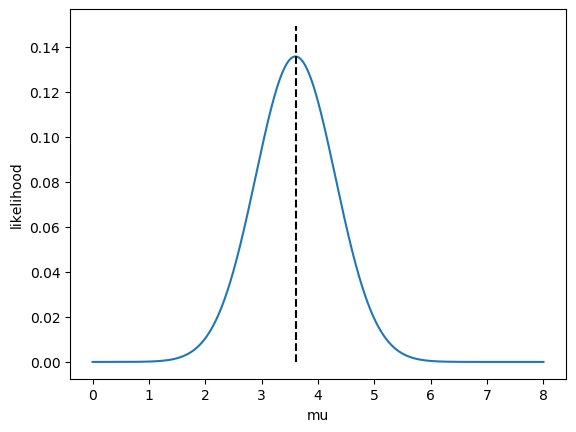

The maximum is at 3.600360


In [39]:
grid = range(0,stop=8,length=10000)
lik = SciPyStats.norm.pdf(4,loc=grid).*SciPyStats.norm.pdf(3.2,loc=grid)
plt.plot(grid,lik);
μ_MLE = grid[argmax(lik)]
Printf.@printf("The maximum is at %f\n", μ_MLE);
plt.xlabel("mu");
plt.ylabel("likelihood");
plt.plot((μ_MLE, μ_MLE),(0,maximum(lik)*1.1),"--k");

Let's look at this for a larger number of observations. I'll generate data from a Gaussian with a true mean of 3 and a true variance of 1. 

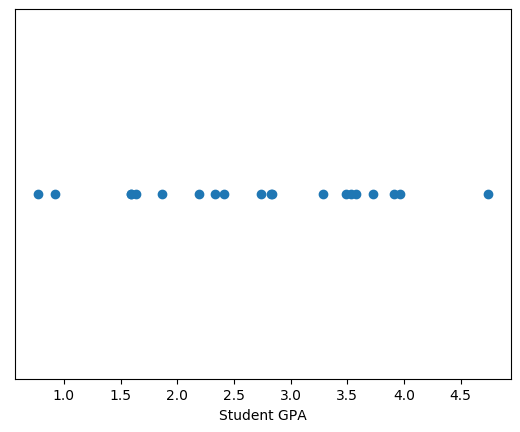

In [93]:
μ = 3
σ = 1
n = 20
data = σ.*randn(n) .+ μ
plt.scatter(data, 0 .*data);
plt.yticks(());
plt.xlabel("Student GPA");

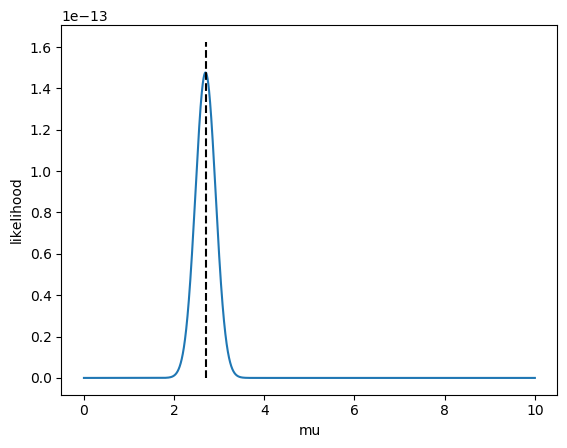

The maximum is at 2.696270


In [94]:
grid = range(0,stop=10,length=10000)
pbs = SciPyStats.norm(loc=reshape(grid,10000,1),scale=σ).pdf(data)
lik = [prod(pbs[i,:]) for i in 1:size(pbs)[1]]
plt.plot(grid,lik);
μ_MLE = grid[argmax(lik)]
Printf.@printf("The maximum is at %f\n", μ_MLE);
plt.xlabel("mu");
plt.ylabel("likelihood");
plt.plot((μ_MLE, μ_MLE),(0,maximum(lik)*1.1),"--k");

Our estimate of the mean is quite close to the true mean, which is reassuring. We can overlay this distribution on the data to see what it looks like:

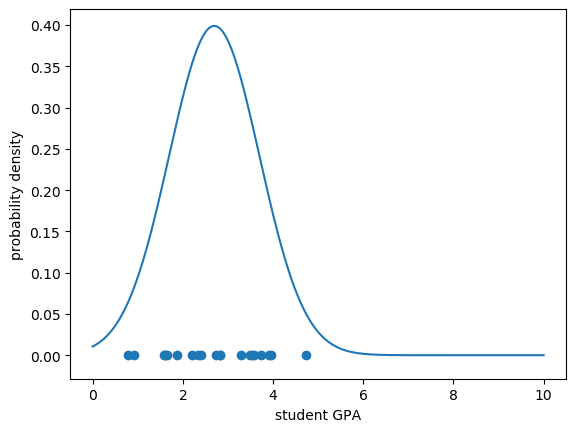

In [95]:
plt.scatter(data,0 .*data)
plt.plot(grid, SciPyStats.norm.pdf(grid, loc=μ_MLE,scale=σ));
plt.xlabel("student GPA");
plt.ylabel("probability density");

Now, what if we don't know $\sigma$ either? Now we have 2 parameters...



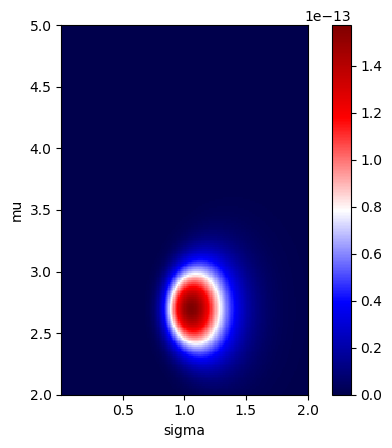

In [96]:
gridσ = range(0.001,stop=2,length=200)
gridμ = range(2,stop=5,length=200)
meshσ = repeat(gridσ',200,1)
meshμ = repeat(gridμ,1,200)

pbs = SciPyStats.norm(loc=meshμ,scale=meshσ).logpdf(reshape(data,20,1,1))
lik = [sum(pbs[:,i,j]) for i in 1:size(pbs)[2], j in 1:size(pbs)[3]]

plt.imshow(broadcast(exp,lik),extent=(minimum(gridσ), maximum(gridσ), minimum(gridμ), maximum(gridμ)), origin="lower", cmap=plt.cm.seismic);
plt.xlabel("sigma")
plt.ylabel("mu")
plt.colorbar();

What am I looking at?

- This is still a univariate Gaussian!!!! 
  - Try not to confuse multiple observations from a univariate Gaussian with one observation from a multivariate Gaussian
- So, in this case we have have multiple parameters _and_ multiple observations

### Digression: numerical issues

If you've taken CPSC 302/303 you're heard of floating point errors. Let's say we have 5000 observations:

In [103]:
μ = 3
σ = 1
n = 100
grid = range(0,stop=10,length=10000)
data = σ.*randn(n) .+ μ
pbs = SciPyStats.norm(loc=reshape(grid,10000,1),scale=σ).pdf(data)
lik = [prod(pbs[i,:]) for i in 1:size(pbs)[1]]
lik

10000-element Array{Float64,1}:
 5.786551096727066e-259 
 7.822672902354828e-259 
 1.0574190044347813e-258
 1.4292085769491973e-258
 1.9315265315845702e-258
 2.610130996231277e-258 
 3.5267972380983853e-258
 4.764915921902236e-258 
 6.437045122580111e-258 
 8.695096915166987e-258 
 1.1744076252279862e-257
 1.586060902634683e-257 
 2.1417926247900687e-257
 ⋮                      
 0.0                    
 0.0                    
 0.0                    
 0.0                    
 0.0                    
 0.0                    
 0.0                    
 0.0                    
 0.0                    
 0.0                    
 0.0                    
 0.0                    

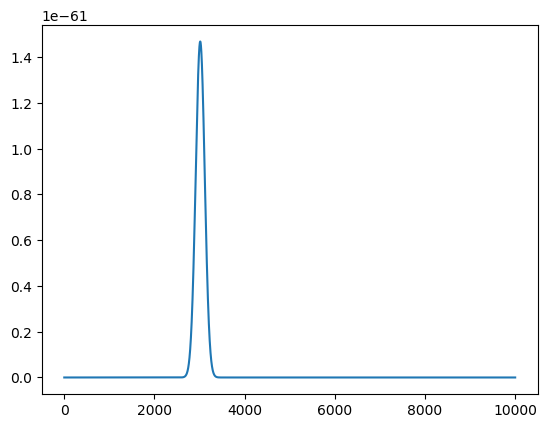

In [105]:
plt.plot(lik);

Hmm...

The problem here is numerical underflow. We can get around this by maximizing the log likelihood instead of the likelihood (same argmax). 

$$p(y \mid w)=\prod_{i=1}^n p(y_i \mid w)$$

So

$$\log p(y \mid w)=\log \prod_{i=1}^n p(y_i \mid w) = \sum_{i=1}^n \log p(y_i \mid w)$$

In [110]:
pbs = SciPyStats.norm(loc=reshape(grid,length(grid),1),scale=σ).logpdf(data)
log_lik = [sum(pbs[i,:]) for i in 1:size(pbs)[1]]
log_lik

10000-element Array{Float64,1}:
  -594.6140026368569
  -594.3125127859319
  -594.0111229550098
  -593.7098331440907
  -593.4086433531746
  -593.1075535822617
  -592.8065638313516
  -592.5056741004445
  -592.2048843895404
  -591.9041946986395
  -591.6036050277414
  -591.3031153768463
  -591.0027257459545
     ⋮              
 -2571.8388228026747
 -2572.5363327417176
 -2573.233942700764 
 -2573.931652679812 
 -2574.6294626788645
 -2575.3273726979196
 -2576.0253827369766
 -2576.7234927960385
 -2577.4217028751027
 -2578.1200129741696
 -2578.818423093239 
 -2579.5169332323126

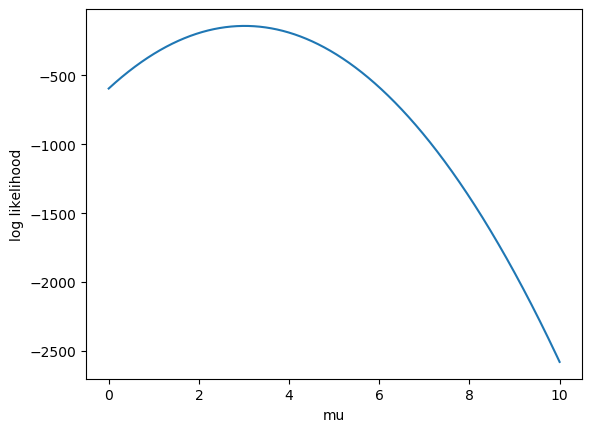

In [111]:
plt.plot(grid,log_lik);
plt.xlabel("mu");
plt.ylabel("log likelihood");